In [1]:
# This is my main NumPy implementation of the density matrix generation code. It should be noted that it probably does not give a 
# distribution of states that is uniform in any useful way.

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import dataclasses


@dataclasses.dataclass
class Params:
    mu0: float
    mu1: float
    mu2: float
    r: float
    zeta: float
    theta: float
    psi: float
    theta_prime: float
    psi_prime: float
    theta32: float
    psi32: float
    theta21: float
    psi21: float
    theta0: float
    psi0: float

    @property
    def mu3(self):
        return 1 - self.mu0 - self.mu1 - self.mu2

In [3]:
def sample_params(samps):
    # These distributions are verified to work for pure states
    
    unif = np.random.uniform
    
    _theta = np.arccos(unif(-1, 1, samps))
    _psi = unif(0, 2 * np.pi, samps)
    _theta_prime = np.arccos(unif(-1, 1, samps))
    _psi_prime = unif(0, 2 * np.pi, samps)
    _r = np.cbrt(unif(0, 1, samps))
    _zeta = unif(0, 2 * np.pi, samps)

    # what follows is purely a guess
    mu = np.random.dirichlet(np.ones(4), samps)  # sample mu's uniformly from the random simplex
    _theta32 = np.arccos(unif(-1, 1, samps))  # sample thetas and psis as for pure states
    _psi32 = unif(0, 2 * np.pi, samps)
    _theta21 = np.arccos(unif(-1, 1, samps))
    _psi21 = unif(0, 2 * np.pi, samps)
    _theta0 = np.arccos(unif(-1, 1, samps))
    _psi0 = unif(0, 2 * np.pi, samps)

    return Params(mu0=mu[:, 0], mu1=mu[:, 1], mu2=mu[:, 2], r=_r, zeta=_zeta, theta=_theta, psi=_psi,
                  theta_prime=_theta_prime, psi_prime=_psi_prime, theta32=_theta32, psi32=_psi32, theta21=_theta21,
                  psi21=_psi21, theta0=_theta0, psi0=_psi0, )

In [4]:
def sample_pure(samps):
    unif = np.random.uniform
    
    _theta = np.arccos(unif(-1, 1, samps))
    _psi = unif(0, 2 * np.pi, samps)
    _theta_prime = np.arccos(unif(-1, 1, samps))
    _psi_prime = unif(0, 2 * np.pi, samps)
    _r = np.cbrt(unif(0, 1, samps))
    _zeta = unif(0, 2 * np.pi, samps)
    
    zero = np.zeros(samps)
    _mu0 = np.ones(samps)

    return Params(mu0=_mu0, mu1=zero, mu2=zero, r=_r, zeta=_zeta, theta=_theta, psi=_psi,
                  theta_prime=_theta_prime, psi_prime=_psi_prime, theta32=zero, psi32=zero, theta21=zero,
                  psi21=zero, theta0=zero, psi0=zero, )

In [5]:
def make_cs(theta, psi):
    return np.exp(-1j * psi / 2) * np.cos(theta / 2), np.exp(1j * psi / 2) * np.sin(theta / 2)


def make_s_mat(theta, psi, theta_prime, psi_prime):
    c, s = make_cs(theta, psi)
    c_prime, s_prime = make_cs(theta_prime, psi_prime)

    conj = np.conjugate

    return np.array([
                    [c * c_prime, conj(s) * conj(s_prime),
                     -c * conj(s_prime), -(conj(s)) * c_prime, ],
            
                    [c * s_prime, -(conj(s)) * conj(c_prime),
                     c * conj(c_prime), -(conj(s)) * s_prime, ],
            
                    [s * c_prime, -(conj(c)) * conj(s_prime),
                     -s * conj(s_prime), conj(c) * c_prime, ],
            
                    [s * s_prime, conj(c) * conj(c_prime),
                     s * conj(c_prime), conj(c) * s_prime, ], ]).transpose((2, 0, 1))
    # Each parameter is a 1D array, so the output is a 3D array consisting of a 2D array (matrix) whose elements are lists.
    # The transpose operation restructures the 3D output array so it is a list of matrices instead

In [6]:
def make_rho_mat(params):
    q_plus = np.sqrt((1 + params.r) / 2)
    q_minus = np.sqrt((1 - params.r) / 2)

    c32, s32 = make_cs(params.theta32, params.psi32)
    c21, s21 = make_cs(params.theta21, params.psi21)
    c0, s0 = make_cs(params.theta0, params.psi0)

    conj = np.conjugate
    abs = np.absolute

    rho00 = ((params.mu0 - params.mu3) * q_plus ** 2 + (params.mu1 - params.mu3) * q_minus ** 2 * abs(c21) ** 2
             + (params.mu2 - params.mu3) * q_minus ** 2 * abs(c0) ** 2 * abs(s21) ** 2 + params.mu3)

    rho01 = ((params.mu0 - params.mu3) * np.exp(-1j * params.zeta) * q_minus * q_plus
             - (params.mu1 - params.mu3) * np.exp(-1j * params.zeta) * q_minus * q_plus * abs(c21) ** 2
             - (params.mu2 - params.mu3) * np.exp(-1j * params.zeta) * q_plus * q_minus * abs(c0) ** 2 * abs(s21) ** 2)

    rho02 = (-(params.mu1 - params.mu3) * np.exp(-1j * params.zeta) * q_minus * c21 * conj(c32) * conj(s21)
             + (params.mu2 - params.mu3) * np.exp(-1j * params.zeta) * q_minus * c0 * conj(s21) * (
                     conj(c0) * c21 * conj(c32) - conj(s0) * s32))

    rho03 = (-(params.mu1 - params.mu3) * np.exp(-1j * params.zeta) * q_minus * c21 * conj(s32) * conj(s21)
             + (params.mu2 - params.mu3) * np.exp(-1j * params.zeta) * q_minus * c0 * conj(s21) * (
                     conj(c0) * c21 * conj(s32) + conj(s0) * c32))

    rho10 = ((params.mu0 - params.mu3) * np.exp(1j * params.zeta) * q_minus * q_plus
             - (params.mu1 - params.mu3) * np.exp(1j * params.zeta) * q_minus * q_plus * abs(c21) ** 2
             - (params.mu2 - params.mu3) * np.exp(1j * params.zeta) * q_minus * q_plus * abs(c0) ** 2 * abs(s21) ** 2)

    rho11 = ((params.mu0 - params.mu3) * q_minus ** 2 + (params.mu1 - params.mu3) * q_plus ** 2 * abs(c21) ** 2
             + (params.mu2 - params.mu3) * q_plus ** 2 * abs(c0) ** 2 * abs(s21) ** 2 + params.mu3)

    rho12 = ((params.mu1 - params.mu3) * q_plus * c21 * conj(c32) * conj(s21)
             - (params.mu2 - params.mu3) * q_plus * c0 * conj(s21) * (
                     conj(c0) * c21 * conj(c32) - conj(s0) * s32))

    rho13 = ((params.mu1 - params.mu3) * q_plus * c21 * conj(s32) * conj(s21)
             - (params.mu2 - params.mu3) * q_plus * c0 * conj(s21) * (
                     conj(c0) * c21 * conj(s32) + conj(s0) * c32))

    rho20 = (-(params.mu1 - params.mu3) * np.exp(1j * params.zeta) * q_minus * conj(c21) * c32 * s21
             + (params.mu2 - params.mu3) * np.exp(1j * params.zeta) * q_minus * conj(c0) * s21 * (
                     c0 * conj(c21) * c32 - s0 * conj(s32)))

    rho21 = ((params.mu1 - params.mu3) * q_plus * conj(c21) * c32 * s21
             - (params.mu2 - params.mu3) * q_plus * conj(c0) * s21 * (c0 * conj(c21) * c32 - s0 * conj(s32)))

    rho22 = ((params.mu1 - params.mu3) * abs(c32) ** 2 * abs(s21) ** 2
             + (params.mu2 - params.mu3) * abs(c0 * conj(c21) * c32 - s0 * conj(s32)) ** 2 + params.mu3)

    rho23 = ((params.mu1 - params.mu3) * abs(s21) ** 2 * c32 * conj(s32) + (params.mu2 - params.mu3) * (
            conj(c0) * c21 * conj(s32) + conj(s0) * c32) * (
                     c0 * conj(c21) * c32 - s0 * conj(s32)))

    rho30 = (-(params.mu1 - params.mu3) * np.exp(1j * params.zeta) * q_minus * conj(c21) * s32 * s21
             + (params.mu2 - params.mu3) * np.exp(1j * params.zeta) * q_minus * conj(c0) * s21 * (
                     c0 * conj(c21) * s32 + s0 * conj(c32)))

    rho31 = ((params.mu1 - params.mu3) * q_plus * conj(c21) * s32 * s21
             - (params.mu2 - params.mu3) * q_plus * conj(c0) * s21 * (c0 * conj(c21) * s32 + s0 * conj(c32)))

    rho32 = ((params.mu1 - params.mu3) * abs(s21) ** 2 * conj(c32) * s32
             + (params.mu2 - params.mu3) * (c0 * conj(c21) * s32 + s0 * conj(c32)) * (
                     conj(c0) * c21 * conj(c32) - conj(s0) * s32))

    rho33 = ((params.mu1 - params.mu3) * abs(s21) ** 2 * abs(s32) ** 2
             + (params.mu2 - params.mu3) * abs(c0 * conj(c21) * s32 + s0 * conj(c32)) ** 2 + params.mu3)

    return np.array([[rho00, rho01, rho02, rho03], [rho10, rho11, rho12, rho13],
                     [rho20, rho21, rho22, rho23], [rho30, rho31, rho32, rho33], ]).transpose((2, 0, 1))
    # Each parameter is a 1D array, so the output is a 3D array consisting of a 2D array (matrix) whose elements are lists.
    # The transpose operation restructures the 3D output array so it is a list of matrices instead

In [7]:
def make_rho_prime_mat(params):
    s_mat = make_s_mat(params.theta, params.psi, params.theta_prime, params.psi_prime)
    rho = make_rho_mat(params)
    s_dagger = np.conjugate(s_mat.transpose((0, 2, 1)))  # This one is just an actual transpose of each matrix in the list
    return np.matmul(s_mat, np.matmul(rho, s_dagger))

In [10]:
### unit test (as in, one of them) ###

p = Params(
    mu0=np.array([0.5,0.5], dtype="complex256"),
    mu1=np.array([0.25,0.25], dtype="complex256"),
    mu2=np.array([.2,0.25], dtype="complex256"),
    r=np.array([0.25,.75], dtype="complex256"),
    zeta=np.array([np.pi, 3*np.pi/2], dtype="complex256"),
    theta=np.array([np.pi / 5, np.pi/2], dtype="complex256"),
    psi=np.array([np.pi / 3, 11*np.pi/6], dtype="complex256"),
    theta_prime=np.array([np.pi / 3, 7*np.pi/8], dtype="complex256"),
    psi_prime=np.array([np.pi / 2, 13*np.pi/24], dtype="complex256"),
    theta0=np.array([3 * np.pi / 2, 7*np.pi/6], dtype="complex256"),
    psi0=np.array([np.pi / 2, 0], dtype="complex256"),
    theta21=np.array([np.pi / 2, np.pi/3], dtype="complex256"),
    psi21=np.array([0, 5*np.pi/4], dtype="complex256"),
    theta32=np.array([np.pi / 2, np.pi/7], dtype="complex256"),
    psi32=np.array([3 * np.pi / 2, np.pi], dtype="complex256"),
)
rho_prime = make_rho_prime_mat(p)
rho_prime

array([[[ 0.31527774+2.54109884e-21j,  0.01216335-9.18240721e-02j,
          0.02423271-7.52546547e-02j,  0.03021712+2.28857079e-02j],
        [ 0.01216335+9.18240721e-02j,  0.26396039-6.35274710e-21j,
          0.04198577+4.85660284e-02j, -0.05128625+1.08831119e-01j],
        [ 0.02423271+7.52546547e-02j,  0.04198577-4.85660284e-02j,
          0.27443885+1.27054942e-21j, -0.00552253+9.85164780e-02j],
        [ 0.03021712-2.28857079e-02j, -0.05128625-1.08831119e-01j,
         -0.00552253-9.85164780e-02j,  0.14632302-1.27054942e-21j]],

       [[ 0.23730269+2.54109884e-21j, -0.03113797-4.17596996e-02j,
         -0.07501871-7.11876747e-03j, -0.0376405 -5.29239301e-02j],
        [-0.03113797+4.17596996e-02j,  0.32409731+9.31736242e-21j,
          0.05490746+1.05341589e-01j,  0.07215979+8.28041517e-02j],
        [-0.07501871+7.11876747e-03j,  0.05490746-1.05341589e-01j,
          0.09518626-8.47032947e-22j,  0.01822409-6.48878484e-02j],
        [-0.0376405 +5.29239301e-02j,  0.07215979-8.2

In [8]:
rho_prime = make_rho_prime_mat(sample_params(1000000))
#rho_prime = make_rho_prime_mat(sample_pure(1000000))
# tr = rho_prime.trace(axis1=1, axis2=2)
# h = rho_prime - np.conjugate(rho_prime.transpose((0,2,1)))
# rho_prime_sq = np.matmul(rho_prime, rho_prime)
# pur = rho_prime_sq.trace(axis1=1, axis2=2)

(1000000, 4, 4)

In [42]:
def clean_mat(mat, n):
    #this function probably takes longer to run than it's worth ¯\_(ツ)_/¯
    error_array = np.full(mat.shape, 10**(-n))
    output = np.where((np.abs(np.imag(mat)) < error_array), np.real(mat), mat)
    return np.where(((np.abs(np.real(output)) < error_array) & (np.abs(np.imag(output) < error_array))), np.zeros(output.shape), output)

In [39]:
# %timeit make_rho_prime_mat(sample_params(1000000))
# %timeit rho_prime = make_rho_prime_mat(sample_pure(1000000))

In [50]:
rho2 = np.matmul(rho_prime,rho_prime)
np.trace(rho2,axis1=1,axis2=2) - np.trace(clean_mat(rho2, 10),axis1=1,axis2=2)

array([0.+3.37186876e-17j, 0.+1.08420217e-19j, 0.+1.59377719e-17j, ...,
       0.-4.11996826e-17j, 0.+1.32272665e-17j, 0.+3.03576608e-18j])

((0.2500026951498306+0j), (0.9859370403758216+0j), (0.40009727589280936+0j))

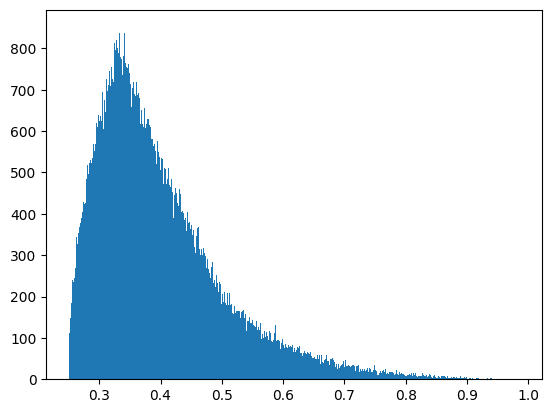

In [44]:
pur = np.trace(clean_mat(np.matmul(rho_prime,rho_prime),8),axis1=1,axis2=2)
plt.hist(pur, bins=5000)
min(pur), max(pur), np.mean(pur)
#minimum purity should be 1/d where d is the dimension of the Hilbert space (here d=4)

In [0]:
np.real_if_close(np.linalg.det(rho_prime))
#np.where(abs(rho_prime - np.zeros(rho_prime.shape)))